In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import lightgbm

import optuna.integration as opt
import optuna.integration.lightgbm as lgb_tuner
import optuna

import datetime as dt

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# Load data
data_len = 1560

df_w = load_data(file_name=f"df_weekly_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_weekly_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [5]:
# predicted is y col
data_dict.update(predicted="sp_close_lead1")

# Model features

In [6]:
# select model features
cols = [item for item in data_dict["relevant_cols"] if "lead" not in item]
cols = [
    'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     # 'pc_ratio',
     'aaii_Bullish',
     'aaii_Bearish',
     'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
]

# predictors are all X cols
data_dict.update(predictor=[item for item in cols if item != data_dict["predicted"]])

In [7]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

# Cross corr

In [8]:
df_cross_corr(df_ws,
              # cols,
              [item for item in cols if item not in data_dict["sp_cols"]],
              data_dict["predicted"],
              show_plot=False,
              no_lags=20,
              figsize=(6, 3))

[['vixo', 0, 0.47],
 ['ff_M_RF', 0, 0.468],
 ['ff_SMB', 12, 0.09],
 ['ff_HML', 15, 0.08],
 ['ff_RMW', 0, 0.138],
 ['ff_CMA', 0, 0.106],
 ['termspread', 0, 0.093],
 ['aaii_Bullish', 0, 0.12],
 ['aaii_Bearish', 0, 0.119],
 ['aaii_Neutral', 11, 0.078]]

In [9]:
# df_ws = shift_var_relative_to_df(df_ws, shift_var=[# "vixo",
#                                                   ], no_lags=[
#     # 6
# ])

# Multi corr

,VIF,corr_sp_close_lead1
vixo,1.875123,-0.470477
ff_RMW,1.220715,-0.138401
aaii_Bearish,3.891603,-0.119020
ff_CMA,1.556369,-0.105523
termspread,1.044800,-0.092697
sp_close_lag4,4.316080,-0.046606
sp_close_lag7,3.048785,-0.030106
sp_close_lag5,5.627046,-0.014199
sp_close_lag6,5.540837,-0.008314
ff_SMB,1.127887,0.017925


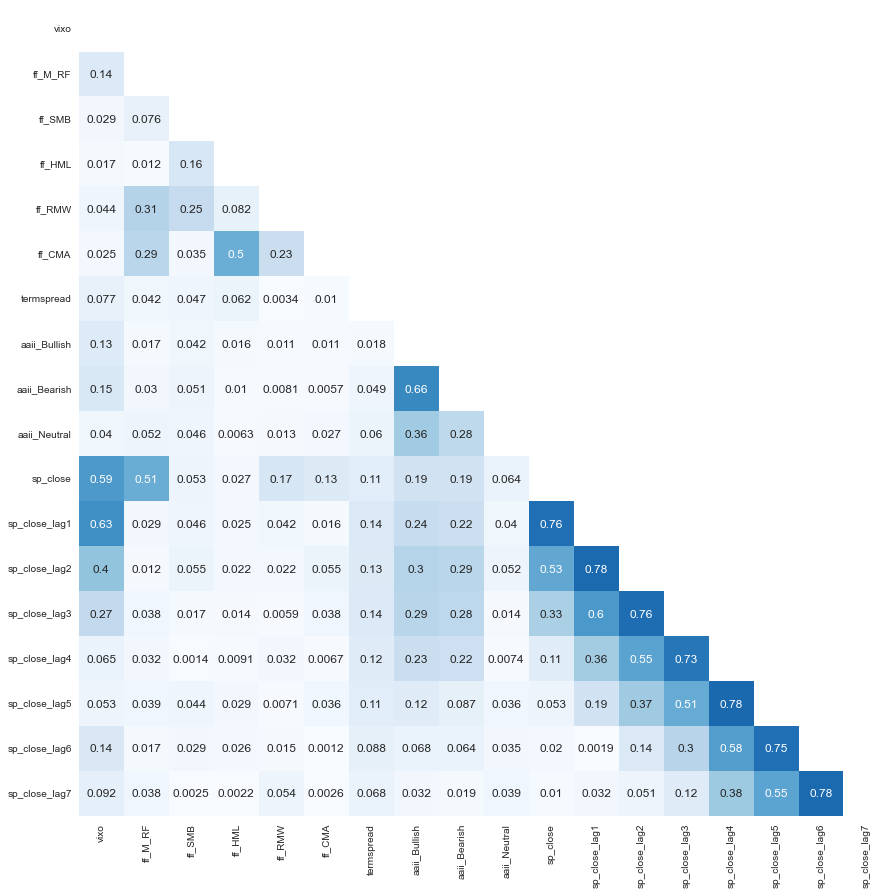

In [10]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["predicted"])

# tts & standard scaling

In [11]:
df_train = df_ws.copy()

In [12]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, add_const=False, random_split=False, test_size=.2)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns)

# Tuner

In [14]:
tuner_params = {
    'objective': 'regression',
    'metric': ['neg_mean_squared_error', 'l2'],
    'random_state': random_state
}

tuner_train = lightgbm.Dataset(X_train, y_train)
tuner_eval = lightgbm.Dataset(X_test, y_test, reference=tuner_train)
tuner_eval_results = {}
training_time = 60 * 10

In [ ]:
%%capture
my_study = optuna.study.create_study()

t_start = dt.datetime.now()
tuner = lgb_tuner.LightGBMTuner(tuner_params,
                                tuner_train,
                                valid_sets=tuner_eval,
                                study=my_study,
                                num_boost_round=1000,
                                time_budget=training_time,
                                callbacks=[lightgbm.early_stopping(10000), lightgbm.record_evaluation(tuner_eval_results)]
                               )
tuner.run()
t_end = dt.datetime.now()

[I 2022-03-13 16:43:52,561] A new study created in memory with name: no-name-24e2c434-68f7-4d0a-af5d-9b274a1e4264
[I 2022-03-13 16:43:53,831] Trial 0 finished with value: 0.00024156491129783076 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.00024156491129783076.
[I 2022-03-13 16:43:55,097] Trial 1 finished with value: 0.00023673524911974053 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.00023673524911974053.
[I 2022-03-13 16:43:56,493] Trial 2 finished with value: 0.00023673524911974053 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.00023673524911974053.
[I 2022-03-13 16:43:57,773] Trial 3 finished with value: 0.00023673524911974053 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.00023673524911974053.
[I 2022-03-13 16:43:58,861] Trial 4 finished with value: 0.00023268320820458638 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 0.000232683208204586

In [ ]:
print(f'Parameters where tuned for {t_end - t_start}')
print(f'Max training time was {training_time}')

In [46]:
tuner.best_params

{'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'objective': 'regression',
 'metric': ['neg_mean_squared_error', 'l2'],
 'random_state': 101,
 'feature_pre_filter': False}

In [47]:
params = {'objective': 'regression',
 'metric': ['neg_mean_squared_error', 'l2'],
 'random_state': 101,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

# Model

In [48]:
lgb_train = lightgbm.Dataset(X_train, y_train)
lgb_test = lightgbm.Dataset(X_test, y_test, reference=lgb_train)
evals_result = {} 

In [49]:
%%capture
model = lightgbm.train(tuner.best_params,
                           lgb_train,
                           num_boost_round=250,
                           valid_sets=[lgb_test, lgb_train],
                           callbacks=[lightgbm.early_stopping(100000), lightgbm.record_evaluation(evals_result)])

# Model eval

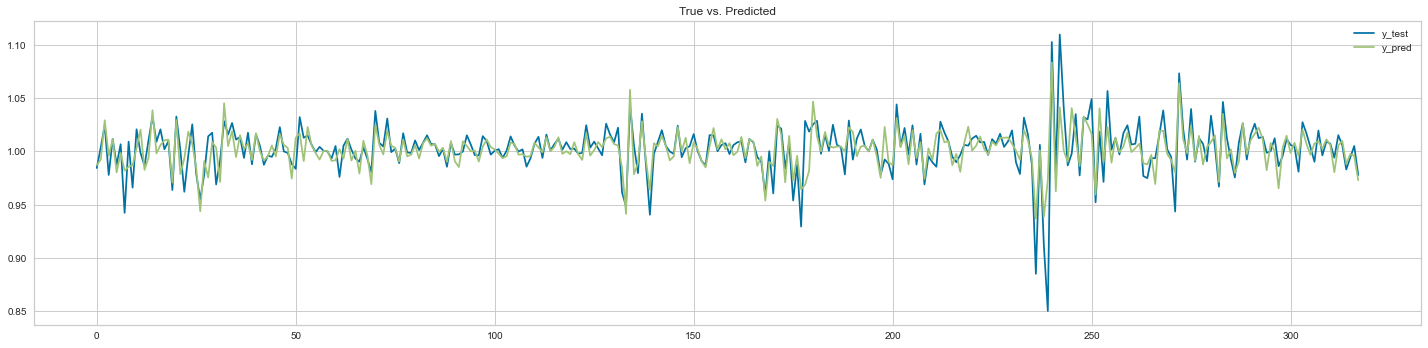

Validation Scores
mean squared error: 0.000239
mean absolute error: 0.010235
R2: 0.580101


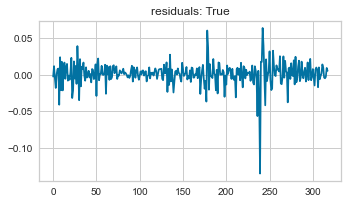

Stationarity Test Results
P-Values: 2.8764579665915e-18
Test-stats: -10.32892773661563
Time series is stationary: True


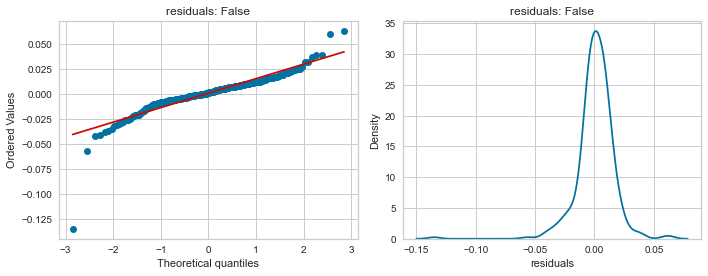

Normality Test Results
P-Values: 2.3484752360547988e-42
Test-stats: 191.7096152478004
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


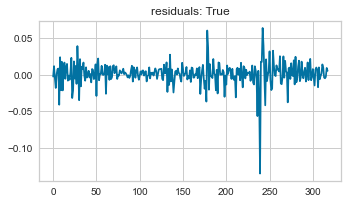

Test for Heteroskedasticity
Test p-value: 3.098097127365861e-08
Heteroskedasticity is present: True


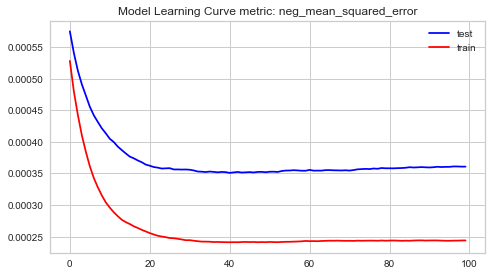

In [50]:
lgb_eval = ModelValidation(X_train=X_train,
                           y_train=y_train,
                           X_validate=X_test,
                           y_validate=y_test,
                           model=model,
                           data_dict=data_dict)

lgb_eval.get_model_performance()
lgb_eval.analyse_resids(print_results=True)
lgb_eval.lgbm_learning_curve(tuner.best_params, lgb_train, lgb_test, "Model Learning Curve")

In [51]:
data_dict

{'data_cols': {'fears': ['fears25', 'fears30', 'fears35'],
  'cbeo_vix': ['vixo', 'vixh', 'vixl', 'vix'],
  'naaim_risk': ['Mean/Average',
   'naaim_max',
   'naaim_q1',
   'Quart 2 (median)',
   'Quart 3 (25% at/above)',
   'Most Bullish Response',
   'naaim_std',
   'naaim_ind',
   'S&P 500'],
  'ff_factors5': ['ff_M_RF', 'ff_SMB', 'ff_HML', 'ff_RMW', 'ff_CMA', 'ff_RF'],
  'termspread': ['termspread'],
  'put_call': ['Call', 'Put', 'Total', 'pc_ratio'],
  'aaii_bull': ['aaii_Bullish',
   'aaii_Neutral',
   'aaii_Bearish',
   'aaii_Total',
   'aaii_Bullish 8-week Mov Avg',
   'aaii_Bull-Bear Spread',
   'aaii_Bullish Average',
   'aaii_Bullish Average +St. Dev.',
   'aaii_Bullish Average - St. Dev.'],
  'sp500': ['sp_Open',
   'sp_High',
   'sp_Low',
   'sp_close',
   'sp_adj_close',
   'sp_volume'],
  'goog_sent': ['goog_sent']},
 'sp_true_vals': 'sp_true_vals',
 'sp_cols': ['sp_close',
  'sp_close_lead14',
  'sp_close_lead13',
  'sp_close_lead12',
  'sp_close_lead11',
  'sp_close_le

# Save model

In [29]:
save_model(df_train, model, lgb_eval, data_dict, name=f"lgb_{data_len}_{data_dict['predicted']}", file_path=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-13_lgb_1560_sp_close_lead1_model.pkl"? (y/n)


 n
